In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import time
import math
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import PIL 
from tqdm import tqdm
import matplotlib.pyplot as plt
# tsne and pca
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import untils
from DeepTaxonNet import DeepTaxonNet
import argparse
import utils

from sklearn.mixture import GaussianMixture
import test_utils
import os
import sys

In [33]:
def is_power_of_two(n: int) -> bool:
    """Checks if a number is an integer power of 2."""
    return (n > 0) and (n & (n - 1) == 0)

def find_parent_simple(index: int, n_leaves: int) -> int:
    """
    Finds the parent index based *only* on node index and number of leaves,
    assuming a perfectly balanced binary tree with adjacent merges.

    *** WARNING: Assumes a VERY specific, regular tree structure. ***
    - n_leaves MUST be a power of 2.
    - List order: [leaves 0..N-1, internals N..2N-2] where N=n_leaves.
    - Merges assumed: (0,1)->N; (2,3)->N+1; ... ; (N, N+1)->N+N/2; etc.

    Args:
        index (int): The index of the node (leaf or internal).
                     Use -1 to explicitly request the parent of the root (returns -1).
        n_leaves (int): The total number of leaf nodes. MUST be a power of 2.

    Returns:
        int: The index of the parent node in the flattened structure.
             Returns -1 if the input index corresponds to the root node or if
             the input index was -1.

    Raises:
        ValueError: If n_leaves is not > 1 and a power of two, or if the
                    input index is outside the valid range [0, 2*n_leaves - 2].
        RuntimeError: If logic fails to find a parent for a valid internal node.
                      (Indicates an issue with the assumptions or code).
    """
    if not isinstance(n_leaves, int) or n_leaves <= 1:
        raise ValueError("n_leaves must be an integer greater than 1.")
    if not is_power_of_two(n_leaves):
         raise ValueError(f"n_leaves ({n_leaves}) must be a power of 2 for this simplified function.")

    # The root node is the last element in the full list of size 2*n_leaves - 1
    root_index = 2 * n_leaves - 2

    # Handle cases for the root node
    if index == -1 or index == root_index:
        return -1

    # Validate index range (0 to root_index inclusive)
    if not (0 <= index <= root_index):
        raise ValueError(f"Index {index} is out of the valid range [0, {root_index}].")

    # --- Determine Parent Index ---

    # Case 1: Index corresponds to a leaf node (0 to n_leaves - 1)
    if index < n_leaves:
        # Parent is the first level of internal nodes.
        # Pair (0,1) -> parent N; Pair (2,3) -> parent N+1, etc.
        # Parent index = N + floor(leaf_index / 2)
        parent_index = n_leaves + (index // 2)
        return parent_index

    # Case 2: Index corresponds to an internal node (n_leaves to root_index - 1)
    else:
        # We need to determine which "level" the internal node is in
        # and calculate the parent based on its position within that level.
        current_level_start = n_leaves      # Index of the first node in the current level
        current_level_size = n_leaves // 2  # Number of nodes in the first internal level

        while current_level_size >= 1:
            current_level_end = current_level_start + current_level_size - 1

            # Check if the index falls within the current level being examined
            if current_level_start <= index <= current_level_end:
                # Calculate the start index of the parent level
                parent_level_start = current_level_end + 1
                # Find the index's relative position (0-based) within its level
                offset_in_level = index - current_level_start
                # Calculate the parent index: start of parent level + floor(offset / 2)
                parent_index = parent_level_start + (offset_in_level // 2)
                return parent_index

            # If not in this level, move to the next level up the tree
            current_level_start = current_level_end + 1  # Start of the next level
            current_level_size //= 2                     # Size halves at each level

        # This part should not be reached if the input index is valid and < root_index
        raise RuntimeError(f"Internal logic error: Could not determine parent for internal node index {index}.")


In [34]:
train_loader, test_loader, train_set, test_set = utils.get_data_loader('fashion-mnist', 128, False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/nethome/zwang910/miniconda3/envs/dl/lib/python3.13/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [35]:
n_layers=10

## For MNIST / Fashion-MNIST
model = DeepTaxonNet(
    n_layers=n_layers,
    enc_hidden_dim=128*1*1,
    dec_hidden_dim=(128,1,1),
    input_dim=1*28*28,
    latent_dim=10,
    encoder_name='omniglot',
    decoder_name='omniglot',
    kl1_weight=1
).to(device)

## For CIFAR-10
# model = DeepTaxonNet(
#     n_layers=n_layers,
#     enc_hidden_dim=512*1*1,
#     dec_hidden_dim=(512,1,1),
#     input_dim=3*32*32,
#     latent_dim=64,
#     encoder_name='resnet18',
#     decoder_name='resnet18',
#     kl1_weight=1
# ).to(device)


path = './models/'
# run = 'vade-10-rec-10-reg-1.2-cifar/'
# run = 'vade-10-rec-5-reg-1.2-fmnist/'
# run = 'vade-11-reg-1-fmnist/'
model_name = 'dtn-10-fmnist.pt'
model.load_state_dict(torch.load(f'{path}{model_name}'))

<All keys matched successfully>

# Visualize Test Set Samples

In [36]:

def plot_dataset_examples(model, test_loader, start_offset=0, n_nodes=10, n_examples=5, device='cpu'):
    top_latents = []

    pcx = []
    test_set_img = []

    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            # Get the latent representation for the batch
            _, recon_loss, kl1, kl2, H, pcx_batch, pi, _ = model(images)
            # Get the pcx values for the batch
            pcx.append(pcx_batch.cpu())
            test_set_img.append(images.cpu())

    # Concatenate all pcx values and test_set images
    pcx = torch.cat(pcx, dim=0)
    test_set_img = torch.cat(test_set_img, dim=0)
    # print('test_set_img', test_set_img.shape)
    # print('pcx', pcx.shape)
    
    n_clusters = pcx.shape[1]

    for c in range(n_clusters):
        pcx = torch.tensor(pcx, device=device)
        # For cluster c, get the top_k indices from the batch with highest pcx values.
        top_values, top_indices = torch.topk(pcx[:, c], n_examples, dim=0)
        # Gather the corresponding latent vectors, shape: (top_k, n_hidden)
        # Note: all_latents is assumed to be a tensor of shape (n_samples, n_hidden)
        # all_latents is a numpy array, so we need to convert it to a tensor
        test_set_img = torch.tensor(test_set_img, device=device)
        cluster_latents = test_set_img[top_indices]
        top_latents.append(cluster_latents.unsqueeze(0))  # unsqueeze to add cluster dimension

    # Concatenate along the cluster dimension: resulting shape is (n_clusters, top_k, n_hidden)
    output = torch.cat(top_latents, dim=0)
    print(f"output shape: {output.shape}")
    # Reshape to (n_clusters * top_k, n_hidden)
    # output = output.view(-1, output.shape[-1])
    # with torch.no_grad():
        # Decode the latent vectors to get the generated images
        # generated_images = model.decode(output)
        # Reshape to (n_clusters, top_k, C, H, W)
    # generated_images = generated_images.view(len(top_latents), n_examples, *generated_images.shape[1:])
    # Move to CPU and convert to numpy
    generated_images = output.cpu().numpy()
    # print(f"generated_images shape: {generated_images.shape}")
    n = generated_images.shape[0]  # total number of nodes: should equal 2^L - 1
    # L = int(np.log2(n + 1))  # calculate the number of layers L
    # start = 2**L - 2**(layer + 1)
    # end = start + 2**layer
    start = start_offset
    end = start + n_nodes
    generated_images = generated_images[start:end, ...]
    # print(f"generated_images shape: {generated_images.shape}")
    # print()


    # Create subplots: n_clusters rows and n_examples columns.
    fig, axes = plt.subplots(end-start, n_examples, figsize=(n_examples, end-start))
    # Force the axes array to be 2D.
    if end-start == 1 and n_examples == 1:
        axes = np.array([[axes]])
    elif end-start == 1:
        axes = np.expand_dims(axes, axis=0)
    elif n_examples == 1:
        axes = np.expand_dims(axes, axis=1)
        
    # Loop over clusters and examples to display each generated image.
    for i in range(end-start):
        for j in range(n_examples):
            ax = axes[i, j]
            img = generated_images[i, j]
            # If the image is grayscale (1 channel), remove the extra dimension.
            if img.shape[0] == 1:
                img = img.squeeze(0)
                ax.imshow(img, cmap='gray')
            else:
                # For color images, convert from (C, H, W) to (H, W, C)
                # img = np.transpose(img, (1, 2, 0))
                # print(f"img shape: {img.shape}")
                # print(f"img shape: {img.shape}")
                ax.imshow(img.transpose(1, 2, 0))
            ax.axis("off")  # Remove axis ticks and labels
    
    # Remove spacing between subplots.
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, top=1, bottom=0)
    return fig

/tmp/ipykernel_3948899/1664848258.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pcx = torch.tensor(pcx, device=device)
/tmp/ipykernel_3948899/1664848258.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_set_img = torch.tensor(test_set_img, device=device)


output shape: torch.Size([2047, 10, 1, 28, 28])


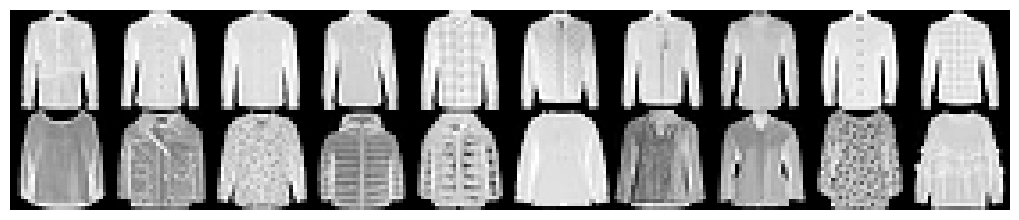

In [43]:
# Remember the how cluster list is layered, so the first 2^L - 1 clusters are the leaves.
# e.g, cluster_list = [leaf1, leaf2, leaf3, leaf4, ..., root]
# Start_offest is the index of the first cluster in the list to plot.
# n_nodes is the number of clusters to plot, from start_offset.
# n_examples is the number of examples to plot for each cluster.
# If you want to plot the parent of the cluster you want, use the find_parent function to find the index of the parent cluster.

fig = plot_dataset_examples(model, test_loader, start_offset=10, n_nodes=2, n_examples=10, device=device)
fig.show()

parent_idx 1029


/tmp/ipykernel_3948899/1664848258.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pcx = torch.tensor(pcx, device=device)
/tmp/ipykernel_3948899/1664848258.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_set_img = torch.tensor(test_set_img, device=device)


output shape: torch.Size([2047, 10, 1, 28, 28])


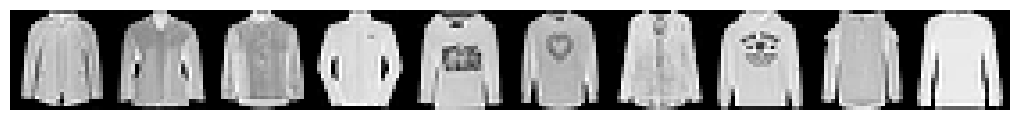

In [44]:
parent_idx = find_parent_simple(10, 2**n_layers)
print('parent_idx', parent_idx)
fig = plot_dataset_examples(model, test_loader, start_offset=parent_idx, n_nodes=1, n_examples=10, device=device)
fig.show()

# Visualize Generated Examples

,u_c.shape: torch.Size([2047, 10])


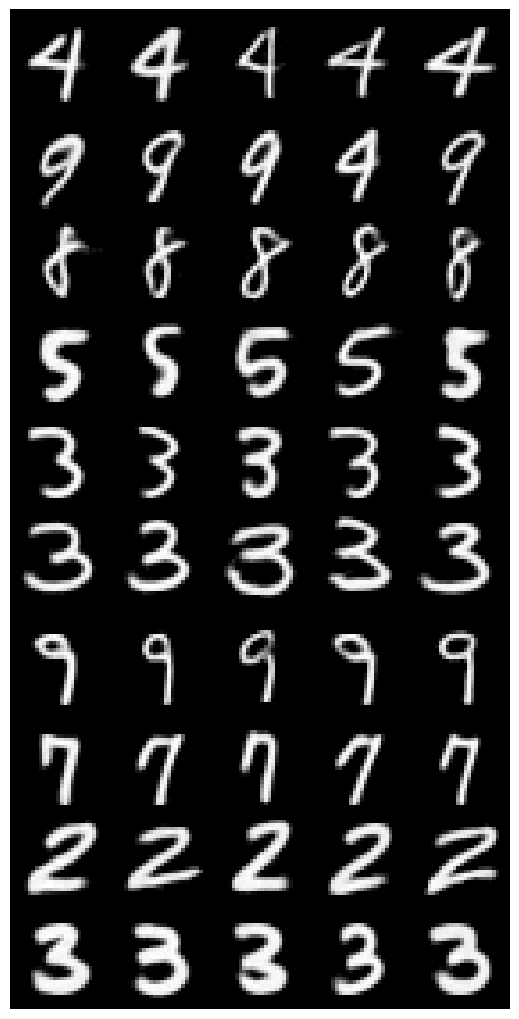

In [25]:
offset = 60
# layer = 10
n_examples = 5
subset_len = 10

pi, mu_c, logvar_c, H, alphas, dkl_list = model.gmm_params()
print(',u_c.shape:', mu_c.shape)

mu_c = mu_c[offset:offset+subset_len, :].unsqueeze(1).expand(-1, n_examples, -1).reshape(-1, mu_c.shape[-1]) # shape: (n_clusters * n_examples, n_hidden)
logvar_c = logvar_c[offset:offset+subset_len, :].unsqueeze(1).expand(-1, n_examples, -1).reshape(-1, logvar_c.shape[-1]) # shape: (n_clusters * n_examples, n_hidden)

# print(f"mu_c shape: {mu_c.shape}")
# break

eps = torch.randn_like(mu_c)  # shape: (n_clusters * n_examples, n_hidden) 
# make the noise smaller
eps = eps
z = mu_c + torch.exp(logvar_c / 2) * eps  # shape: (n_clusters * n_examples, n_hidden)
x = model.decode(z.to(device))  # shape: (n_clusters * n_examples, C, H, W)
x = x.view(-1, n_examples, *x.shape[1:]).detach().cpu().numpy()  # shape: (n_clusters, n_examples, C, H, W)

n_clusters = x.shape[0]

# generate small noise for each cluster for each example
# Create subplots: n_clusters rows and n_examples columns.
fig, axes = plt.subplots(n_clusters, n_examples, figsize=(n_examples, n_clusters))
# Force the axes array to be 2D.
if n_clusters == 1 and n_examples == 1:
    axes = np.array([[axes]])
elif n_clusters == 1:
    axes = np.expand_dims(axes, axis=0)
elif n_examples == 1:
    axes = np.expand_dims(axes, axis=1)
    
# Loop over clusters and examples to display each generated image.
for i in range(n_clusters):
    for j in range(n_examples):
        ax = axes[i, j]
        img = x[i, j]
        # If the image is grayscale (1 channel), remove the extra dimension.
        if img.shape[0] == 1:
            img = img.squeeze(0)
            ax.imshow(img, cmap='gray')
        else:
            # For color images, convert from (C, H, W) to (H, W, C)
            # img = np.transpose(img, (1, 2, 0))
            # print(f"img shape: {img.shape}")
            # print(f"img shape: {img.shape}")
            ax.imshow(img.transpose(1, 2, 0))
        ax.axis("off")  # Remove axis ticks and labels

# Remove spacing between subplots.
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, top=1, bottom=0)
# return fig
plt.show()